This package will walk through how to run a straightforward experiment on quantum memory experiments using the MWPM decoder. 

In [1]:
# Create a circuit representing the experiment - this circuit has no noise!
from dotg.circuits import SurfaceCode
print(SurfaceCode.Rotated.__doc__)
code_object = SurfaceCode.Rotated(distance=5, rounds=5, memory_basis='x')
noiseless_circuit = code_object.memory

Rotated surface code class. After initialisation, access circuits for quantum
        memory and stability experiments with the `memory` and `stability` properties.
        Parameters
        ----------
        distance : int
            Code distance in both X and Z directions.
        rounds : int, optional
            Number of rounds to run the code for, by default None. If None, defaults
            to the code distance.
        memory_basis : str, optional
            Which logical memory to encode, by default Z.

        Raises
        ------
        ValueError
            If memory_basis kwarg is not one of X, x, Z or z.
        


Stim has handy functionality that creates quantum memory circuits automagically. This is done in the minimal universal gateset for the memory basis. Since this circuit has no noise, we need to choose our noise model.

In [2]:
from dotg.noise import DepolarizingNoise

print(DepolarizingNoise.__doc__)
noise_model = DepolarizingNoise(physical_error=1e-3)

noisy_circuit = noise_model.permute_circuit(noiseless_circuit)

Class that allows application of depolarizing noise onto a noiseless stim circuit.
    It takes in a single parameter, physical_error, which acts as the two qubit gate
    noise and the measurement noise. All other noise parameters (single quibt gates
    and reset gates) take the value physical_error*0.1.

    Parameters
    ----------
    physical_error : float
        Probability of a physical error occurring at any one location in the
        quantum circuit.

    Raises
    ------
    ValueError
        If physical_error does not lie in the range (0, 1).
    


The `permute_circuit` method applies the noise model to the circuit, including idle noise. At the moment the noise model types are quite restricted, i.e. you can only define a `reset_noise` attribute --- you can't define different noise models for different reset gates, i.e. `RX` and `RZ`.

In [3]:
from dotg.decoders import MinimumWeightPerfectMatching

decoder = MinimumWeightPerfectMatching(circuit=noisy_circuit)

The `.decoders` package currently has `MinimumWeightPerfectMatching` (via the [PyMatching](https://github.com/oscarhiggott/PyMatching) package), as well as `BeliefPropagation` and soon to come `BPOSD` decoders via the [LDPC](https://github.com/quantumgizmos/ldpc/tree/main) package. I plan to add a lot more decoder functionality --- this is higher priority than noise models or stability experiments.

Using the functionality built into the pymatching package, we can straight away get a logical error value from the circuit. All decoders will be outfitted with a similar `logical_error` method, with differing performance metrics.

In [4]:
logical_error = decoder.logical_error(num_shots=1e6)
logical_error

6.7e-05

## COOL

In [5]:
# Let's try a wider range of noise parameters.
import numpy as np
import time as time

# Create your range of physical error parameters
physical_error_params = np.logspace(-4, -2, 20)

# Each physical error gets it's own noise model
noise_models = [DepolarizingNoise(physical_error=phys) for phys in physical_error_params]

# Each of those noise models is used to create a unique circuit
circuits = [
    noise_model.permute_circuit(noiseless_circuit) for noise_model in noise_models
]

# Each circuit must have it's own decoder object!
decoders = [MinimumWeightPerfectMatching(circuit=circ) for circ in circuits]

start = time.time()
logical_errors = [decoder.logical_error(num_shots=1e6) for decoder in decoders]
f"{time.time() - start:.2f}seconds"

# 20million shots in ~19 seconds on an M2 Macbook Air.

'18.10seconds'

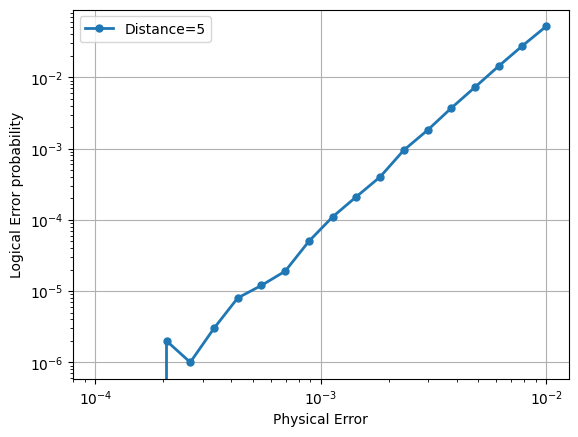

In [6]:
import matplotlib.pyplot as plt

plt.plot(
    physical_error_params,
    logical_errors,
    linewidth=2,
    marker=".",
    markersize=10,
    label=f"Distance={5}",
)
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.xlabel("Physical Error")
plt.yscale("log")
plt.ylabel("Logical Error probability")
plt.show()

## But we can do more!

In [8]:
# Here's the full code for generating a threshold plot of dxdxd memory experiments.

from tqdm import tqdm
import numpy as np

from dotg.circuits import SurfaceCode
from dotg.decoders import MinimumWeightPerfectMatching
from dotg.noise import DepolarizingNoise

DISTANCES = [3, 5, 7, 9]
PHYSICAL_ERROR_PARAMS = np.logspace(-3, -2, 20)
NUM_SHOTS = 1e5


noiseless_circuits = [SurfaceCode.Rotated(distance=d).memory for d in DISTANCES]
noise_models = [DepolarizingNoise(physical_error=phys) for phys in PHYSICAL_ERROR_PARAMS]


def noisy_circuit(noiseless_circuit, noise_model):
    return noise_model.permute_circuit(noiseless_circuit)


def decoder(distance, physical_error):
    noiseless_circuit = noiseless_circuits[DISTANCES.index(distance)]
    noise_model = noise_models[np.where(PHYSICAL_ERROR_PARAMS == physical_error)[0][0]]
    return MinimumWeightPerfectMatching(
        circuit=noisy_circuit(noiseless_circuit, noise_model)
    )


logical_error_data = {}
for distance in tqdm(DISTANCES):
    logical_error_data[distance] = []
    for physical_error in PHYSICAL_ERROR_PARAMS:
        _decoder = decoder(distance=distance, physical_error=physical_error)

        logical_error_data[distance].append(_decoder.logical_error(NUM_SHOTS))

100%|██████████| 4/4 [00:51<00:00, 12.78s/it]


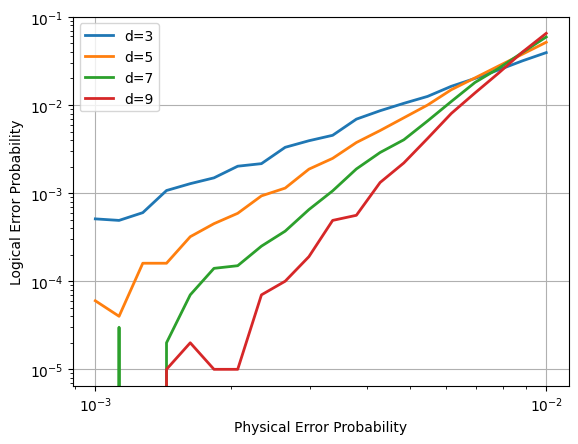

In [9]:
import matplotlib.colors as mpc
import matplotlib.pyplot as plt
colors = list(mpc.TABLEAU_COLORS)

for idx, distance in enumerate(DISTANCES):
    plt.plot(PHYSICAL_ERROR_PARAMS, logical_error_data[distance], linewidth=2, label=f"d={distance}", color=colors[idx])

plt.ylabel("Logical Error Probability")
plt.xlabel("Physical Error Probability")
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.show()

4 (distances) * 20 (physical errors) * 1e5 (shots) = 8million samples in ~50 seconds on an M2 Macbook Air. The threshold is about 0.7%, what we expect for this noise model.